In [8]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, TimeDistributed, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [1]:
import pandas as pd
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

from collections import Counter
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, mean_squared_error, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from IPython.display import display
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error

from datetime import datetime
import plotly  as py
py.tools.set_credentials_file(username='mcmanusdatascience', api_key='Mkw1SmxGJj1HPglRqBES')
import plotly.graph_objs as go
import plotly.tools as tls

from numpy import concatenate

import warnings
warnings.filterwarnings("ignore")

import pandas_datareader.data as web
import datetime as dt
from datetime import date
import re
from sklearn import preprocessing
import scipy.stats  as stats

from math import sqrt

In [297]:
#import data and 
atvi = pd.read_csv(r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\atvi_master_final_2.csv')
atvi.Date = pd.to_datetime(atvi.Date)
atvi.index = atvi.Date

#split data for training and testing

train  = atvi.loc[:'2018-11-02']
test  = atvi.loc['2018-11-02':]

In [298]:
# split data for training and testing. 
# on nov 2nd 2018 the activision stock was just about to fall pretty hard. let's see if our model can predict this.

atvi_train_nov2nd2018 = atvi.loc[:'11/2/2018']
atvi_test_nov2nd2018 = atvi.loc['11/2/2018':]

In [300]:
#get df with only feature variables
atvi_train_nov2nd2018_fv = atvi_train_nov2nd2018[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
atvi_test_nov2nd2018_fv = atvi_test_nov2nd2018[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]

In [301]:
# convert series to supervised learning (not my code)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# reshape data if needed
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [302]:
# put data into a matrix
train_values = atvi_train_nov2nd2018_fv.values
test_values = atvi_test_nov2nd2018_fv.values

In [303]:
#scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.fit_transform(test_values)

In [304]:
#  data appropriately for lstm
train_reframed = series_to_supervised(train_scaled, 1, 1)
test_reframed = series_to_supervised(test_scaled, 1, 1)

In [305]:
# split into input and outputs - want 2-7 in X, 1 in Y
# remember we do not want to show the current day close prices to this model
train_reframed_x = train_reframed[['var2(t-1)','var3(t-1)','var4(t-1)','var5(t-1)', 'var6(t-1)','var7(t-1)']]
test_reframed_x = test_reframed[['var2(t-1)','var3(t-1)','var4(t-1)','var5(t-1)', 'var6(t-1)', 'var7(t-1)']]
#set up y variables for open and close data
train_reframed_y_close = train_reframed[['var1(t)']]
test_reframed_y_close = test_reframed[['var1(t)']]

In [306]:
# put the dataframe into a matrix
train_reframed_x = train_reframed_x.values
test_reframed_x = test_reframed_x.values
train_reframed_y_close = train_reframed_y_close.values
test_reframed_y_close = test_reframed_y_close.values

In [307]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_reframed_x.reshape((train_reframed_x.shape[0], 1, train_reframed_x.shape[1]))
test_X = test_reframed_x.reshape((test_reframed_x.shape[0], 1, test_reframed_x.shape[1]))
print(train_X.shape, train_reframed_y_close.shape, test_X.shape, test_reframed_y_close.shape)

(760, 1, 6) (760, 1) (155, 1, 6) (155, 1)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 6 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent. Adam is an adapted, quicker version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 31 (1 month). The internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days might provide some added utility in this model.

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [308]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_reframed_y_close, epochs=8, batch_size=31, validation_data=(test_X, test_reframed_y_close), verbose=2, shuffle=False)

Train on 760 samples, validate on 155 samples
Epoch 1/8
 - 3s - loss: 0.2828 - val_loss: 0.1618
Epoch 2/8
 - 0s - loss: 0.2508 - val_loss: 0.2076
Epoch 3/8
 - 0s - loss: 0.2578 - val_loss: 0.2199
Epoch 4/8
 - 0s - loss: 0.2577 - val_loss: 0.2237
Epoch 5/8
 - 0s - loss: 0.2557 - val_loss: 0.2258
Epoch 6/8
 - 0s - loss: 0.2531 - val_loss: 0.2283
Epoch 7/8
 - 0s - loss: 0.2503 - val_loss: 0.2320
Epoch 8/8
 - 0s - loss: 0.2483 - val_loss: 0.2351


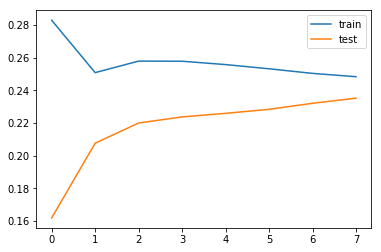

In [309]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [310]:
# make a prediction
predictedclosingprice = model.predict(test_X)
#invert scaling - inverse transform needs to be fed an array of the same shape as before (155, 7)
#replace the actual Y values with the predicted ones and we will be good to go)
test_X1 = test_X.reshape((155,6))
inv_yhat = concatenate((predictedclosingprice, test_X1), axis=1)
# invert scaling for forecast - an array of shape 156, 7 was fed in originally. so i'm assuming I should do the same here.
inv_y_all = scaler.inverse_transform(inv_yhat)
inv_y = inv_y_all[:,0]

In [311]:
#test_y = test_y.reshape((len(test_y), 1))
actualval = concatenate((test_reframed_y_close, test_X1), axis=1)
actualval = scaler.inverse_transform(actualval)
actualval = actualval[:,0]

In [312]:
#model metric
rmse = sqrt(mean_squared_error(inv_y, actualval))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.726


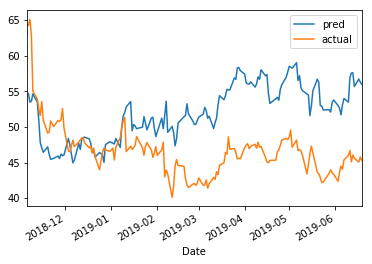

In [313]:
predictedvsactual = pd.DataFrame(atvi.Close.loc['2018-11-05':])
predictedvsactual['pred'] = inv_y
predictedvsactual['actual'] = actualval
predictedvsactual['pred'] = predictedvsactual['pred'].shift(1)
predictedvsactual = predictedvsactual.drop(columns = ['Close'], axis=1)
predictedvsactual.plot()

Provisionally, this looks quite good in predicting volatility and stock price direction movement. Let's take a closer look at what exactly is going on here:

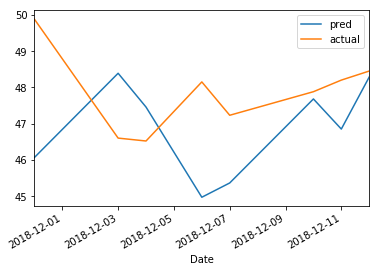

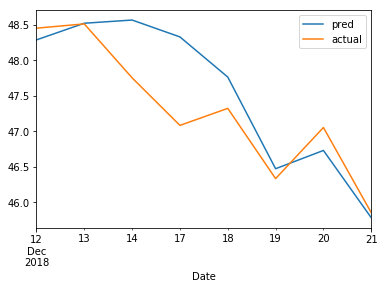

In [314]:
predictedvsactual.loc['2018-11-30':'2018-12-12'].plot()
predictedvsactual.loc['2018-12-12':'2018-12-22'].plot()

On initial inspection:

- RMSE is lower than the RF models. This is a good thing.

- We are not showing this model the stock price at any point. Accordingly, we are removing that potential bias and current day foward projection that we saw in the RF models.

- The model isn't predicting the stock price completely accurately. It is however predicting the volatility and directional movement of the stock price.

As we had our RF model also predict the price 5 days into the future let's attempt this aswell. 

Let's also take a look at what happens when we adapt the model as a classifier.

In [ ]:
# Generate model that predicts stock price movement 5 days out and compare

In [315]:
#  data appropriately for lstm
atvi_lstm = atvi[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
#put in matrix
atvi_lstm_matrix = atvi_lstm.values

# specify the number of lag hours
n_days = 5
# frame as supervised learning
reframed = series_to_supervised(atvi_lstm_matrix, n_days, 1)

In [316]:
reframedtrain = reframed[:760]
reframedtest = reframed[760:]

In [317]:
#normalize data
reframedtrain = scaler.fit_transform(reframedtrain)
reframedtest = scaler.fit_transform(reframedtest)

In [318]:
#put reframed data back in in dataframe for ease of indexing
reframedtrain = pd.DataFrame(reframedtrain)
reframedtest = pd.DataFrame(reframedtest)

In [319]:
#setup training and test data
train_X = reframedtrain.drop(columns=[35,28,21,14,7,0,36,37,38,39,40,41])
test_X = reframedtest.drop(columns=[35,28,21,14,7,0,36,37,38,39,40,41])

train_Y = reframedtrain.iloc[:,35]
test_Y = reframedtest.iloc[:,35]

In [320]:
#put data in matrix so that we can pipe it into our model
train_X = train_X.values
test_X = test_X.values
train_Y = train_Y.values
test_Y = test_Y.values

In [321]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 5, 6))
test_X = test_X.reshape((test_X.shape[0], 5, 6))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(760, 5, 6) (760,) (151, 5, 6) (151,)


In [322]:
train_X.shape

(760, 5, 6)

In [323]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=20, batch_size=31, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 760 samples, validate on 151 samples
Epoch 1/20
 - 3s - loss: 0.1150 - val_loss: 0.6305
Epoch 2/20
 - 0s - loss: 0.4531 - val_loss: 0.2206
Epoch 3/20
 - 0s - loss: 0.2613 - val_loss: 0.2552
Epoch 4/20
 - 0s - loss: 0.2558 - val_loss: 0.2963
Epoch 5/20
 - 0s - loss: 0.2624 - val_loss: 0.3156
Epoch 6/20
 - 0s - loss: 0.2511 - val_loss: 0.3443
Epoch 7/20
 - 0s - loss: 0.2474 - val_loss: 0.3612
Epoch 8/20
 - 0s - loss: 0.2312 - val_loss: 0.3822
Epoch 9/20
 - 0s - loss: 0.2380 - val_loss: 0.3815
Epoch 10/20
 - 0s - loss: 0.2190 - val_loss: 0.4014
Epoch 11/20
 - 0s - loss: 0.2381 - val_loss: 0.3715
Epoch 12/20
 - 0s - loss: 0.2060 - val_loss: 0.3959
Epoch 13/20
 - 0s - loss: 0.2355 - val_loss: 0.3720
Epoch 14/20
 - 0s - loss: 0.2003 - val_loss: 0.4012
Epoch 15/20
 - 0s - loss: 0.2317 - val_loss: 0.3745
Epoch 16/20
 - 0s - loss: 0.1968 - val_loss: 0.3990
Epoch 17/20
 - 0s - loss: 0.2306 - val_loss: 0.3687
Epoch 18/20
 - 0s - loss: 0.1927 - val_loss: 0.3926
Epoch 19/20
 - 0s - loss: 0

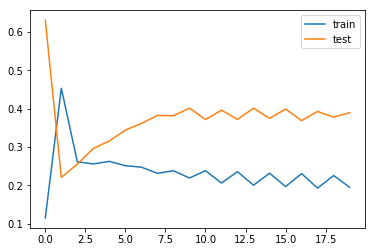

In [324]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [245]:
#loss function converges for test and train data around 3-4 epochs so let's run with that.

In [325]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=4, batch_size=31, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 760 samples, validate on 151 samples
Epoch 1/4
 - 3s - loss: 0.1285 - val_loss: 0.5420
Epoch 2/4
 - 0s - loss: 0.4390 - val_loss: 0.2293
Epoch 3/4
 - 0s - loss: 0.2776 - val_loss: 0.2428
Epoch 4/4
 - 0s - loss: 0.2583 - val_loss: 0.2784


In [326]:

# reinitate original dataframe so we can inversely transform the predictions
reframed = series_to_supervised(atvi_lstm_matrix, 5, 1)
reframedtest1 = reframed[760:]
real = reframedtest1['var1(t)']
# make a prediction - append it to original dataframe
predictedclosingprice = model.predict(test_X)
reframedtest1['var1(t)'] = predictedclosingprice
# invert scaling for forecast 
inv_y_all = scaler.inverse_transform(reframedtest1)
predicted = inv_y_all[:,35]


In [328]:
#new dataframe to compare predicted versus actual

predvsactual = pd.DataFrame()
predvsactual['real'] = real
predvsactual['pred'] = predicted
# the fact that the predicted data is the predicted price for 5 days in the future needs to be accounted for
predvsactual['pred'] = predvsactual['pred'].shift(5)


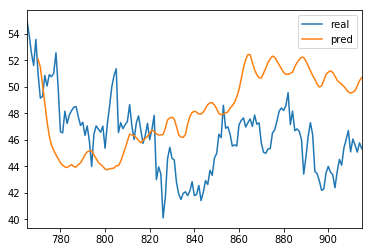

In [329]:
predvsactual.plot()

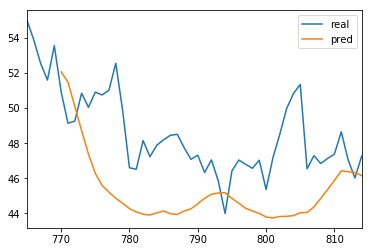

In [330]:
predvsactual.iloc[0:50].plot()

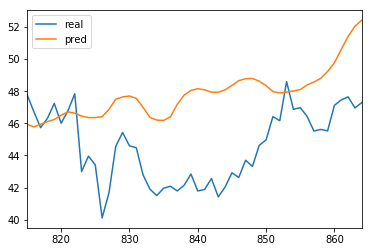

In [331]:
predvsactual.iloc[50:100].plot()

In [335]:
#model metric
rmse = sqrt(mean_squared_error(predvsactual['real'].loc[775:], predvsactual['pred'].loc[775:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.547


This model is not catching the huge downturn in the stock price. It is however catching other trends. Notably, we are getting a further decrease in RMSE.

It is alot more smoothed than the 1 day model. Of note is that this model is not predicting 5 days into the future. It is predicting the next day using the previous 5 days. In this sense, this model is a good comparator for our RF model. That being said, we are maintaing some intrinsic weaknesses to the utility of this model. It also seems that given that the LSTM is not picking up on the downturn of this stock. It would be reasonable to adapt the point at which we split the test and train groups.


Let's try a model that predicts 5 days into the future using the preceeding 14 days.

In [336]:
#  data appropriately for lstm
atvi_lstm = atvi[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
#put in matrix
atvi_lstm_matrix = atvi_lstm.values

# specify the number of lag hours
n_days = 19
# frame as supervised learning
reframed = series_to_supervised(atvi_lstm_matrix, n_days, 1)

In [154]:
# our first predicted date should be 2015-11-24	36.840000 - this should correpond to column 133
#unhash the line below to double check this
#reframed.iloc[:,133]

In [399]:
# reset the train test split to move it foward
reframedtrain = reframed[:815]
reframedtest = reframed[815:]

In [338]:
#normalize data
reframedtrain = scaler.fit_transform(reframedtrain)
reframedtest = scaler.fit_transform(reframedtest)

In [339]:
#put reframed data back in in dataframe for ease of indexing
reframedtrain = pd.DataFrame(reframedtrain)
reframedtest = pd.DataFrame(reframedtest)

In [340]:
#setup training and test data
train_X = reframedtrain.drop(columns=[56,63,70,77,84,91,98,105,112,119,126,133,49,42,35,28,21,14,7,0,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139])
test_X = reframedtest.drop(columns=[56,63,70,77,84,91,98,105,112,119,126,133,49,42,35,28,21,14,7,0,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139])

train_Y = reframedtrain.iloc[:,133]
test_Y = reframedtest.iloc[:,133]

In [341]:
#put data in matrix so that we can pipe it into our model
train_X = train_X.values
test_X = test_X.values
train_Y = train_Y.values
test_Y = test_Y.values

In [342]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 16, 6))
test_X = test_X.reshape((test_X.shape[0], 16, 6))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(815, 16, 6) (815,) (82, 16, 6) (82,)


In [343]:
train_X.shape

(815, 16, 6)

In [344]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=25, batch_size=31, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 815 samples, validate on 82 samples
Epoch 1/25
 - 4s - loss: 0.1290 - val_loss: 0.2691
Epoch 2/25
 - 1s - loss: 0.3947 - val_loss: 0.1843
Epoch 3/25
 - 1s - loss: 0.2809 - val_loss: 0.1743
Epoch 4/25
 - 1s - loss: 0.2753 - val_loss: 0.1770
Epoch 5/25
 - 1s - loss: 0.2717 - val_loss: 0.1797
Epoch 6/25
 - 1s - loss: 0.2672 - val_loss: 0.1822
Epoch 7/25
 - 1s - loss: 0.2619 - val_loss: 0.1852
Epoch 8/25
 - 1s - loss: 0.2589 - val_loss: 0.1885
Epoch 9/25
 - 1s - loss: 0.2574 - val_loss: 0.1909
Epoch 10/25
 - 1s - loss: 0.2526 - val_loss: 0.1965
Epoch 11/25
 - 1s - loss: 0.2524 - val_loss: 0.1989
Epoch 12/25
 - 1s - loss: 0.2436 - val_loss: 0.2112
Epoch 13/25
 - 1s - loss: 0.2513 - val_loss: 0.2064
Epoch 14/25
 - 1s - loss: 0.2408 - val_loss: 0.2202
Epoch 15/25
 - 1s - loss: 0.2452 - val_loss: 0.2109
Epoch 16/25
 - 1s - loss: 0.2378 - val_loss: 0.2196
Epoch 17/25
 - 1s - loss: 0.2385 - val_loss: 0.2140
Epoch 18/25
 - 1s - loss: 0.2338 - val_loss: 0.2257
Epoch 19/25
 - 1s - loss: 0.

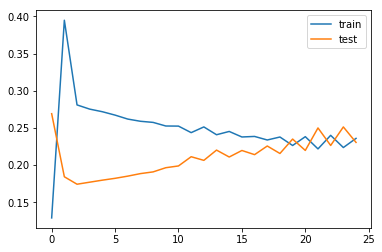

In [345]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [346]:

# reinitate original dataframe so we can inversely transform the predictions
reframed = series_to_supervised(atvi_lstm_matrix, 19, 1)
reframedtest1 = reframed[815:]
real = reframedtest1['var1(t)']
# make a prediction - append it to original dataframe
predictedclosingprice = model.predict(test_X)
reframedtest1['var1(t)'] = predictedclosingprice
# invert scaling for forecast 
inv_y_all = scaler.inverse_transform(reframedtest1)
predicted = inv_y_all[:,133]

In [347]:
#new dataframe to compare predicted versus actual

predvsactual = pd.DataFrame()
predvsactual['real'] = real
predvsactual['pred'] = predicted
# the fact that the predicted data is the predicted price for n days in the future needs to be accounted for
predvsactual['real'] = predvsactual['real']
predvsactual['pred'] = predvsactual['pred'].shift(+16)

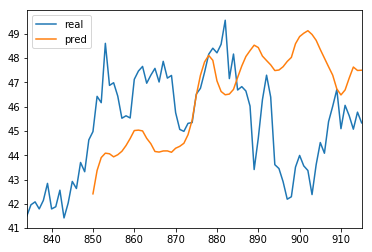

In [348]:
predvsactual.plot()

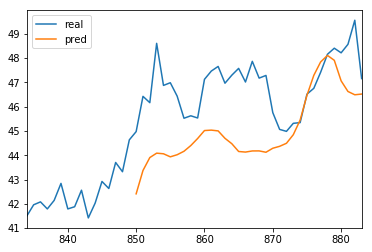

In [349]:
predvsactual.iloc[0:50].plot()

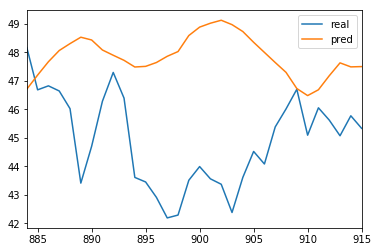

In [350]:
predvsactual.iloc[50:100].plot()

In [352]:
#model metric
rmse = sqrt(mean_squared_error(predvsactual['real'].loc[850:], predvsactual['pred'].loc[850:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.970


Based on RMSE this is our best model yet, further more we're truly predicting 5 days into the future with the model. The features for this model are a 14 day series of features whose recording date ends 5 days prior to the prediction. According, there is a 5 day window to adjust one's trading strategy.

As we attempted to predict stock price directional movement with our RF models. We will attempt the same here, before deciding on our final model. Let's attempt to predict 5 Day Directional Change.

In [358]:
#  data appropriately for lstm
atvi_lstm = atvi[['5daydirectionchange','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
#put in matrix
atvi_lstm_matrix = atvi_lstm.values

# specify the number of lag hours
n_days = 15
# frame as supervised learning
reframed = series_to_supervised(atvi_lstm_matrix, n_days, 1)

In [408]:
# reset the train test split to move it foward
reframedtrain = reframed[:840]
reframedtest = reframed[840:]

In [409]:
#normalize data
reframedtrain = scaler.fit_transform(reframedtrain)
reframedtest = scaler.fit_transform(reframedtest)

In [410]:
#put reframed data back in in dataframe for ease of indexing
reframedtrain = pd.DataFrame(reframedtrain)
reframedtest = pd.DataFrame(reframedtest)

In [411]:
#setup training and test data
train_X = reframedtrain.drop(columns=[56,63,70,77,84,91,98,105,49,42,35,28,21,14,7,0,])
test_X = reframedtest.drop(columns=[56,63,70,77,84,91,98,105,49,42,35,28,21,14,7,0,])

train_Y = reframedtrain.iloc[:,105]
test_Y = reframedtest.iloc[:,105]

In [412]:
#put data in matrix so that we can pipe it into our model
train_X = train_X.values
test_X = test_X.values
train_Y = train_Y.values
test_Y = test_Y.values

In [413]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 16, 6))
test_X = test_X.reshape((test_X.shape[0], 16, 6))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(840, 16, 6) (840,) (61, 16, 6) (61,)


In [421]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=1000, batch_size=20, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 840 samples, validate on 61 samples
Epoch 1/1000
 - 6s - loss: 0.5121 - val_loss: 0.5235
Epoch 2/1000
 - 1s - loss: 0.5190 - val_loss: 0.5280
Epoch 3/1000
 - 1s - loss: 0.4688 - val_loss: 0.5298
Epoch 4/1000
 - 1s - loss: 0.4905 - val_loss: 0.5339
Epoch 5/1000
 - 1s - loss: 0.4617 - val_loss: 0.5358
Epoch 6/1000
 - 1s - loss: 0.4868 - val_loss: 0.5387
Epoch 7/1000
 - 1s - loss: 0.4555 - val_loss: 0.5396
Epoch 8/1000
 - 1s - loss: 0.4716 - val_loss: 0.5440
Epoch 9/1000
 - 1s - loss: 0.4608 - val_loss: 0.5440
Epoch 10/1000
 - 1s - loss: 0.4604 - val_loss: 0.5442
Epoch 11/1000
 - 1s - loss: 0.4517 - val_loss: 0.5439
Epoch 12/1000
 - 1s - loss: 0.4574 - val_loss: 0.5425
Epoch 13/1000
 - 1s - loss: 0.4467 - val_loss: 0.5391
Epoch 14/1000
 - 1s - loss: 0.4540 - val_loss: 0.5415
Epoch 15/1000
 - 1s - loss: 0.4476 - val_loss: 0.5388
Epoch 16/1000
 - 1s - loss: 0.4457 - val_loss: 0.5352
Epoch 17/1000
 - 1s - loss: 0.4435 - val_loss: 0.5366
Epoch 18/1000
 - 1s - loss: 0.4462 - val_loss:

 - 1s - loss: 0.2109 - val_loss: 0.4551
Epoch 152/1000
 - 1s - loss: 0.2124 - val_loss: 0.4878
Epoch 153/1000
 - 1s - loss: 0.2152 - val_loss: 0.4635
Epoch 154/1000
 - 1s - loss: 0.2134 - val_loss: 0.5013
Epoch 155/1000
 - 1s - loss: 0.2350 - val_loss: 0.4503
Epoch 156/1000
 - 1s - loss: 0.2106 - val_loss: 0.4685
Epoch 157/1000
 - 1s - loss: 0.2095 - val_loss: 0.4464
Epoch 158/1000
 - 1s - loss: 0.2114 - val_loss: 0.4327
Epoch 159/1000
 - 1s - loss: 0.1956 - val_loss: 0.4964
Epoch 160/1000
 - 1s - loss: 0.1960 - val_loss: 0.4680
Epoch 161/1000
 - 1s - loss: 0.1933 - val_loss: 0.4688
Epoch 162/1000
 - 1s - loss: 0.1931 - val_loss: 0.4935
Epoch 163/1000
 - 1s - loss: 0.1976 - val_loss: 0.5061
Epoch 164/1000
 - 1s - loss: 0.1946 - val_loss: 0.4435
Epoch 165/1000
 - 1s - loss: 0.2082 - val_loss: 0.4616
Epoch 166/1000
 - 1s - loss: 0.1917 - val_loss: 0.4511
Epoch 167/1000
 - 1s - loss: 0.1895 - val_loss: 0.4648
Epoch 168/1000
 - 1s - loss: 0.1881 - val_loss: 0.4762
Epoch 169/1000
 - 1s - lo

 - 1s - loss: 0.0757 - val_loss: 0.4443
Epoch 301/1000
 - 1s - loss: 0.0746 - val_loss: 0.4190
Epoch 302/1000
 - 1s - loss: 0.0681 - val_loss: 0.3998
Epoch 303/1000
 - 1s - loss: 0.0667 - val_loss: 0.4070
Epoch 304/1000
 - 1s - loss: 0.0694 - val_loss: 0.4268
Epoch 305/1000
 - 1s - loss: 0.0705 - val_loss: 0.4375
Epoch 306/1000
 - 1s - loss: 0.0773 - val_loss: 0.4464
Epoch 307/1000
 - 1s - loss: 0.0671 - val_loss: 0.4693
Epoch 308/1000
 - 1s - loss: 0.0784 - val_loss: 0.4180
Epoch 309/1000
 - 1s - loss: 0.0705 - val_loss: 0.4600
Epoch 310/1000
 - 1s - loss: 0.0824 - val_loss: 0.4226
Epoch 311/1000
 - 1s - loss: 0.0764 - val_loss: 0.4285
Epoch 312/1000
 - 1s - loss: 0.0801 - val_loss: 0.3945
Epoch 313/1000
 - 1s - loss: 0.0782 - val_loss: 0.3838
Epoch 314/1000
 - 1s - loss: 0.0661 - val_loss: 0.4207
Epoch 315/1000
 - 1s - loss: 0.0690 - val_loss: 0.4272
Epoch 316/1000
 - 1s - loss: 0.0634 - val_loss: 0.4069
Epoch 317/1000
 - 1s - loss: 0.0681 - val_loss: 0.3780
Epoch 318/1000
 - 1s - lo

 - 1s - loss: 0.0359 - val_loss: 0.4018
Epoch 450/1000
 - 1s - loss: 0.0355 - val_loss: 0.4197
Epoch 451/1000
 - 1s - loss: 0.0359 - val_loss: 0.4145
Epoch 452/1000
 - 1s - loss: 0.0373 - val_loss: 0.3995
Epoch 453/1000
 - 1s - loss: 0.0350 - val_loss: 0.4134
Epoch 454/1000
 - 1s - loss: 0.0336 - val_loss: 0.4011
Epoch 455/1000
 - 1s - loss: 0.0410 - val_loss: 0.4349
Epoch 456/1000
 - 1s - loss: 0.0579 - val_loss: 0.3924
Epoch 457/1000
 - 1s - loss: 0.0553 - val_loss: 0.4213
Epoch 458/1000
 - 1s - loss: 0.0631 - val_loss: 0.4461
Epoch 459/1000
 - 1s - loss: 0.0653 - val_loss: 0.4645
Epoch 460/1000
 - 1s - loss: 0.0829 - val_loss: 0.4710
Epoch 461/1000
 - 1s - loss: 0.0624 - val_loss: 0.4375
Epoch 462/1000
 - 1s - loss: 0.0545 - val_loss: 0.4396
Epoch 463/1000
 - 1s - loss: 0.0533 - val_loss: 0.4437
Epoch 464/1000
 - 1s - loss: 0.0479 - val_loss: 0.4685
Epoch 465/1000
 - 1s - loss: 0.0540 - val_loss: 0.4632
Epoch 466/1000
 - 1s - loss: 0.0431 - val_loss: 0.4300
Epoch 467/1000
 - 1s - lo

 - 1s - loss: 0.0218 - val_loss: 0.4316
Epoch 599/1000
 - 1s - loss: 0.0228 - val_loss: 0.4196
Epoch 600/1000
 - 1s - loss: 0.0185 - val_loss: 0.4250
Epoch 601/1000
 - 1s - loss: 0.0231 - val_loss: 0.4368
Epoch 602/1000
 - 1s - loss: 0.0199 - val_loss: 0.4127
Epoch 603/1000
 - 1s - loss: 0.0226 - val_loss: 0.4447
Epoch 604/1000
 - 1s - loss: 0.0296 - val_loss: 0.4218
Epoch 605/1000
 - 1s - loss: 0.0294 - val_loss: 0.4144
Epoch 606/1000
 - 1s - loss: 0.0502 - val_loss: 0.4142
Epoch 607/1000
 - 1s - loss: 0.0469 - val_loss: 0.4473
Epoch 608/1000
 - 1s - loss: 0.0372 - val_loss: 0.4562
Epoch 609/1000
 - 1s - loss: 0.0307 - val_loss: 0.4509
Epoch 610/1000
 - 1s - loss: 0.0342 - val_loss: 0.4445
Epoch 611/1000
 - 1s - loss: 0.0320 - val_loss: 0.4654
Epoch 612/1000
 - 1s - loss: 0.0388 - val_loss: 0.4347
Epoch 613/1000
 - 1s - loss: 0.0264 - val_loss: 0.4180
Epoch 614/1000
 - 1s - loss: 0.0263 - val_loss: 0.4066
Epoch 615/1000
 - 1s - loss: 0.0244 - val_loss: 0.4264
Epoch 616/1000
 - 1s - lo

 - 1s - loss: 0.0244 - val_loss: 0.4197
Epoch 748/1000
 - 1s - loss: 0.0368 - val_loss: 0.4358
Epoch 749/1000
 - 1s - loss: 0.0679 - val_loss: 0.4530
Epoch 750/1000
 - 1s - loss: 0.0738 - val_loss: 0.4514
Epoch 751/1000
 - 1s - loss: 0.0541 - val_loss: 0.4493
Epoch 752/1000
 - 1s - loss: 0.0541 - val_loss: 0.4247
Epoch 753/1000
 - 1s - loss: 0.0397 - val_loss: 0.4639
Epoch 754/1000
 - 1s - loss: 0.0454 - val_loss: 0.4246
Epoch 755/1000
 - 1s - loss: 0.0364 - val_loss: 0.4489
Epoch 756/1000
 - 1s - loss: 0.0257 - val_loss: 0.4522
Epoch 757/1000
 - 1s - loss: 0.0220 - val_loss: 0.4325
Epoch 758/1000
 - 1s - loss: 0.0220 - val_loss: 0.4301
Epoch 759/1000
 - 1s - loss: 0.0169 - val_loss: 0.4276
Epoch 760/1000
 - 1s - loss: 0.0155 - val_loss: 0.4290
Epoch 761/1000
 - 1s - loss: 0.0142 - val_loss: 0.4344
Epoch 762/1000
 - 1s - loss: 0.0152 - val_loss: 0.4282
Epoch 763/1000
 - 1s - loss: 0.0158 - val_loss: 0.4518
Epoch 764/1000
 - 1s - loss: 0.0176 - val_loss: 0.4160
Epoch 765/1000
 - 1s - lo

 - 1s - loss: 0.0109 - val_loss: 0.4077
Epoch 897/1000
 - 1s - loss: 0.0126 - val_loss: 0.4127
Epoch 898/1000
 - 1s - loss: 0.0127 - val_loss: 0.3936
Epoch 899/1000
 - 1s - loss: 0.0158 - val_loss: 0.4103
Epoch 900/1000
 - 1s - loss: 0.0124 - val_loss: 0.4015
Epoch 901/1000
 - 1s - loss: 0.0109 - val_loss: 0.4012
Epoch 902/1000
 - 1s - loss: 0.0100 - val_loss: 0.4040
Epoch 903/1000
 - 1s - loss: 0.0102 - val_loss: 0.4005
Epoch 904/1000
 - 1s - loss: 0.0146 - val_loss: 0.3812
Epoch 905/1000
 - 1s - loss: 0.0182 - val_loss: 0.3883
Epoch 906/1000
 - 1s - loss: 0.0471 - val_loss: 0.4119
Epoch 907/1000
 - 1s - loss: 0.1030 - val_loss: 0.4205
Epoch 908/1000
 - 1s - loss: 0.0904 - val_loss: 0.3908
Epoch 909/1000
 - 1s - loss: 0.0684 - val_loss: 0.4229
Epoch 910/1000
 - 1s - loss: 0.0374 - val_loss: 0.4258
Epoch 911/1000
 - 1s - loss: 0.0301 - val_loss: 0.3970
Epoch 912/1000
 - 1s - loss: 0.0221 - val_loss: 0.3942
Epoch 913/1000
 - 1s - loss: 0.0250 - val_loss: 0.3949
Epoch 914/1000
 - 1s - lo

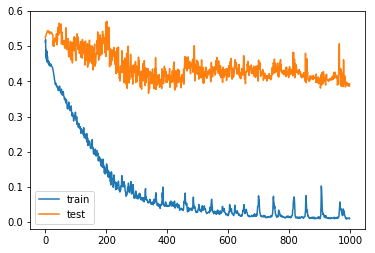

In [422]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

It seems the Neural Network model can learn to pick up the intricacies of how these features move in series and how this correlates with subsequent stock price movement. This model may have some utility and should be back tested. 